### Data Augmentation

**Adding Data Augmentation into the model**

This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:

* Preprocessing of the images (augmenting them) happens on the **GPU** rather than on the CPU (much faster).
* Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

Data augmentation methods that can be adjusted with Keras:

* **RandomFlip** - flips image on horizontal or vertical axis.
* **RandomRotation** - randomly rotates image by a specified amount.
* **RandomZoom** - randomly zooms into an image by specified amount.
* **RandomHeight** - randomly shifts image height by a specified amount.
* **RandomWidth** - randomly shifts image width by a specified amount.
* **Rescaling** - normalizes the image pixel values to be between 0 and 1,

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),  # "horizontal", "vertical", or "horizontal_and_vertical"
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name='data_aug_layer')

# # Example Usage
# data augmentation model requires shape (None, height, width, 3)
# augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
# plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation

### Using Dropout Technique to overcome the Overfitting problem

A form of regularization useful in training neural networks. Dropout regularization removes a random selection of a fixed number of the units in a network layer for a single gradient step. The more units dropped out, the stronger the regularization.

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.2),   # Adding Dropout layer before flatten the data
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes, name="outputs")
])

### Model Layers Describe - Print Model Layer's name, number & trainable state

In [ ]:
def describe_model_layers(model):
  for layer_number, layer in enumerate(model.layers):
    print(layer_number, layer.name, layer.trainable)

### Unzip File

In [ ]:
import zipfile

# Unzip the downloaded file
def unzip_data(zip_file_name):
  zip_ref = zipfile.ZipFile(zip_file_name, "r")
  zip_ref.extractall()
  zip_ref.close()

### Print working or data directory map - walk through directory

In [ ]:
import os

def walk_through_dir(data_dir):
  for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

### Get Images from Directory as Numpy Array

In [ ]:
from tensorflow import keras
import glob   # In order to get images as matrices from directory

def get_imgs_from_directory_as_numpy_array(dir, ext, size=None, scl=None):
    formats = ['jpg', 'png', 'jpeg']

    if ext in formats:
        rgx_for_img = dir + "/*." + ext
        img_list = glob.glob(rgx_for_img)
    def process_images(filename):
        img = keras.preprocessing.image.load_img(filename, color_mode="rgb", target_size=size)
        img_arr = keras.preprocessing.image.img_to_array(img)
        img_arr = np.array(img_arr).astype('float32')
        if scl == '8bit': img_arr /= 255.0
        return img_arr

    return np.array(list(map(process_images, img_list)))
    # https://keras.io/api/preprocessing/image/
    # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

### Get all files from directory with the given file extension (.xml, .jpg, .png, .txt, etc.)

In [ ]:
import os

def get_all_files_ext(path, ext, sort=True):
  '''Get all files with the given file extension in the given path'''
  ext = "." + str(ext)
  files = [
      os.path.join(path, file_name)
      for file_name in os.listdir(path)
      if file_name.endswith(ext)
  ]

  if sort == True:
    return sorted(files)
  else:
    return files

# # Example usage
# ANNOT_PATH = "/content/Microcontroller Detection/train"
# xml_files = get_all_files_ext(ANNOT_PATH, "xml")

### Detecting and Initializing TPU

In [ ]:
import os
import tensorflow as tf

def initialize_TPU():
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']  # For Google Colab
  # For GCP, replace with the actual TPU address
  # tpu_address = 'grpc://<tpu_address>'
  try:
      resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
      print('Running on TPU ', resolver.master())
  except ValueError:
      resolver = None

  if resolver is not None:
      tf.config.experimental_connect_to_cluster(resolver)
      tf.tpu.experimental.initialize_tpu_system(resolver)
      strategy = tf.distribute.TPUStrategy(resolver)
  else:
      strategy = tf.distribute.get_strategy()

  print("TPU REPLICAS: ", strategy.num_replicas_in_sync)

  return strategy

### Prepare Images as Keras Input

In [ ]:
def prepare_imgs_as_keras_input(np_array, input_size):
  '''This method prepares a data array as a keras input
  Example of input_size parameter usage: (28,28,1) -> 28x28 pixels gray scale images, (28,28,3) 28x28 pixels RGB images
  Example of np_array parameter usage: np_array.shape = (60000, 28, 28) OR (60000, 784)'''
  w, h, d = input_size
  return np_array.reshape(np_array.shape[0], w, h, d)

### Preprocess Image File - Load image as tf format, Reshape & Scale

In [ ]:
def preprocess_img(filename, img_shape=224, num_channels=3, scale=True):
  """
  Create a function to import an image and resize it to be able to be used with custom models
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
    Default image size of ResNet model
    Default number of channels=3 (RGB)
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor
  img = tf.image.decode_image(img, channels=num_channels)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  if scale:
    img = img/255.

  return img

### Prediction for given image file & Plots

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

### Prediction Analyzer - Prints DataFrame for Most wrong or Correct Predicted Data


In [ ]:
import pandas as pd

def get_prediction_analysis(img_file_paths, y_true, y_pred, pred_probs, y_true_class_names=None, y_pred_class_names=None, analysis='bad'):
  assert (analysis == 'bad' or  analysis == 'good'), "Invalid analysis type. Please choose one of 'good', 'bad', analysis types"

  dataframe = {"img_path": img_file_paths,
             "y_true": y_true,
             "y_pred": y_pred,
             "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
             "y_true_classname": [class_names[i] for i in y_labels],
             "y_pred_classname": [class_names[i] for i in pred_classes]}

  pred_df = pd.DataFrame(dataframe)
  pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']

  # Get Wrong predictions
  if analysis == 'bad':
    wrong_preds = pred_df[pred_df['pred_correct'] == False]
    wrong_preds = wrong_preds.sort_values('pred_conf', ascending=False)[:100]  # Most wrong 100 predictions
    return wrong_preds
  elif analysis == 'good':
    good_preds = pred_df[pred_df['pred_correct'] == True]
    good_preds = good_preds.sort_values('pred_conf', ascending=False)[:100]  # Most correct 100 predictions
    return good_preds


# # Example Usage
# wrong_preds = get_prediction_analysis(img_file_paths, y_true, y_pred, pred_probs, [class_names[i] for i in y_true], [class_names[i] for i in y_pred])
# wrong_preds.head()
#
# # Visualize some of the most wrong predictions
#
# images_to_view = 16
# start_ix = 11
# plt.figure(figsize=(15,10))
#
# for i, row in enumerate(wrong_preds[start_ix:start_ix+images_to_view].itertuples()):
#   plt.subplot(4, 4, i+1)
#   img = load_and_prep_image(row[1], scale=True)
#   _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
#   plt.imshow(img)
#   plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
#   plt.axis(False)

 ### Parsing Image Annotation Files - PASCAL VOC (xml) format

In [ ]:
import xml.etree.ElementTree as ET

def parse_annotation(xml_file, img_path, class_mapping):
  '''
  Reads the XML file and finds the image name and path, iterates over each
  object in the XML file to extract the bounding box coordinates and class
  labels for each object.

  Returns:
  - The image path
  - List of bounding boxes (each represented as a list of four floats: xmin,
  ymin, xmax, ymax),
  - List of class IDs (represented as integers) corresponding to each bounding
  box. The class IDs are obtained by mapping the class labels to integer values
  using a dictionary called class_mapping.
  '''
  tree = ET.parse(xml_file)
  root = tree.getroot()

  image_name = root.find("filename").text
  image_path = os.path.join(img_path, image_name)

  boxes = []
  classes = []

  for obj in root.iter("object"):
    cls = obj.find("name").text
    classes.append(cls)

    bbox = obj.find("bndbox")

    xmin = float(bbox.find("xmin").text)
    ymin = float(bbox.find("ymin").text)
    xmax = float(bbox.find("xmax").text)
    ymax = float(bbox.find("ymax").text)

    boxes.append([xmin, ymin, xmax, ymax])

  class_ids = [
      list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
      for cls in classes
  ]
  return image_path, boxes, class_ids

# # Example Usage
# IMG_PATH = "/content/Microcontroller Detection/train"    # Contains img files paths
# ANNOT_PATH = "/content/Microcontroller Detection/train"  # Contains xml files paths
#
# class_ids = [
#     "Arduino_Nano",
#     "Heltec_ESP32_Lora",
#     "ESP8266",
#     "Raspberry_Pi_3",
# ]
# class_mapping = dict(zip(range(len(class_ids)), class_ids))
#
# xml_files = get_all_files_ext(ANNOT_PATH, "xml")
# xml_file = xml_files[0]
#
# image_path, boxes, class_ids = parse_annotation(xml_file, IMG_PATH, class_mapping)

### Print Grid Search Results

In [ ]:
def print_grid_search_results(search):
  '''This methods prints Grid Search Results for given search algorithm'''
  print("==== Grid Search Results ====")
  print("best_estimator: ", search.best_estimator_)
  print("best_params:    ", search.best_params_)
  print("best_score:      {:.3f}".format(search.best_score_))

# TF Keras Callbacks

tf.keras.callbacks is a module in TensorFlow that provides various functions that can be used to monitor and modify the behavior of the training process of a neural network. These callbacks can be passed as a list to the fit() method of a tf.keras.Model object, allowing you to customize the training process.

Some of the commonly used callbacks are:

* **ModelCheckpoint**: This callback saves the model after every epoch, or only when an improvement in performance is observed. This helps you to save the best performing model and avoid overfitting. The ModelCheckpoint callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains. This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there. For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

* **EarlyStopping**: This callback stops the training process when the validation loss stops improving. This helps you to avoid overfitting and saves training time.

* **TensorBoard**: This callback writes a log for TensorBoard, which can be used to visualize the model training process, including metrics like loss and accuracy, and graph visualizations of the model architecture.

* **ReduceLROnPlateau**: This callback reduces the learning rate when the validation loss stops improving, which can help you to fine-tune the model.

* **CSVLogger**: This callback writes the training and validation metrics to a CSV file at the end of each epoch, which can be useful for monitoring and analyzing the performance of the model.

These are just a few examples of the many callbacks available in tf.keras.callbacks. You can also create your own custom callbacks by subclassing tf.keras.callbacks.Callback.

### Create Model Checkpoint callback

In [ ]:
import datetime
import tensorflow as tf

def create_model_checkpoint_callback(path, experiment_name, verbose=1):
  # Get Datetime object containing current date and time
  date = str(datetime.now())
  date = (((date.replace("-", "_")).replace(":", "_")).replace(" ", "_")).split(".")[0]

  checkpoint_path = path + "/" + experiment_name + "/" + date + "/checkpoint.ckpt"

  # Create a ModelCheckpoint callback that saves the model's weights only
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         # If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.
                                                         save_best_only=False,   # set to True to save only the best model instead of a model every epoch
                                                         monitor='val_loss',     # Use "loss" or "val_loss" to monitor the model's total loss.
                                                         save_freq='epoch',      # save every epoch
                                                         verbose=1)
  if verbose > 0:
    print(f"Model checkpoint will save to: {checkpoint_path}")

  return checkpoint_callback

# # Example usage
# model_history = model.fit(x_train, y_train, epochs=5, ...,
#                          callbacks=[create_model_checkpoint_callback(dir_name='tensorflow_hub', experimodelB0')])

# # Assigning Multiple callbacks
# model_history = model.fit(x_train, y_train, epochs=5, ...,
#                          callbacks=[create_model_checkpoint_callback(dir_name='tensorflow_hub', experimodelB0'),
#                          create_tensorboard_callback(dir_name='tensorflow_hub', experimodelB0')])
#
# # OR
#
# callback_list = [create_early_stopping_callback(), create_model_checkpoint_callback(dir_name='tensorflow_hub', experimodelB0'), create_tensorboard_callback(dir_name='tensorflow_hub', experimodelB0')]
# model_history = model.fit(x_train, y_train, epochs=5, ..., callbacks=callback_list)

### Create TensorBoard callback

In [ ]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(path, experiment_name, verbose=1):
  '''
  TensorBoard is a visualization tool provided with TensorFlow.
  This callback logs events for TensorBoard, including:

  * Metrics summary plots
  * Training graph visualization
  * Weight histograms
  * Sampled profiling
  '''
  # Get Datetime object containing current date and time
  date = str(datetime.now())
  date = (((date.replace("-", "_")).replace(":", "_")).replace(" ", "_")).split(".")[0]
  log_dir = path + "/" + experiment_name + "/" + date

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir,
      write_graph=True,
      histogram_freq=0,
      '''
      update_freq: 'batch' or 'epoch' or integer. When using 'epoch', writes
      the losses and metrics to TensorBoard after every epoch. If using an
      integer, let's say 1000, all metrics and losses (including custom ones
      added by Model.compile) will be logged to TensorBoard every 1000 batches.
      'batch' is a synonym for 1, meaning that they will be written every batch.
      '''
      update_freq='epoch',
  )

  if verbose > 0:
    print(f"TensorBoard log files will save to: {log_dir}")
  return tensorboard_callback

# # Example usage
# model_history = model.fit(x_train, y_train, epochs=5, ...,
#                          callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', experimodelB0')])

# %load_ext tensorboard
# %tensorboard --logdir=tensorflow_hub

# # Assigning Multiple callbacks
# model_history = model.fit(x_train, y_train, epochs=5, ...,
#                          callbacks=[create_model_checkpoint_callback(dir_name='tensorflow_hub', experimodelB0'),
#                          create_tensorboard_callback(dir_name='tensorflow_hub', experimodelB0')])
#
# # OR
#
# callback_list = [create_early_stopping_callback(), create_model_checkpoint_callback(dir_name='tensorflow_hub', experimodelB0'), create_tensorboard_callback(dir_name='tensorflow_hub', experimodelB0')]
# model_history = model.fit(x_train, y_train, epochs=5, ..., callbacks=callback_list)

### Create Early Stopping callback

In [ ]:
import tensorflow as tf

def create_early_stopping_callback(patience=10, verbose=1):
  # Create a EarlyStopping callback that stops the training process when the validation loss stops improving
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         # min_delta: Minimum change in the monitored quantity to qualify as an improvement,
                                                         # i.e. an absolute change of less than min_delta, will count as no improvement.
                                                         min_delta=0.01,
                                                         # patience: Number of epochs with no improvement after which training will be stopped.
                                                         patience=patience,
                                                         mode='auto'
                                                         # restore_best_weights: Whether to restore model weights from the epoch with the best
                                                         # value of the monitored quantity. If False, the model weights obtained at the last
                                                         # step of training are used. An epoch will be restored regardless of the performance
                                                         # relative to the baseline. If no epoch improves on baseline, training will run for
                                                         # patience epochs and restore weights from the best epoch in that set.
                                                         restore_best_weights=True,
                                                         verbose=verbose)

  return early_stopping_callback

# # Example usage
# model_history = model.fit(x_train, y_train, epochs=5, ...,
#                          callbacks=[create_early_stopping_callback()])

# # Assigning Multiple callbacks
# model_history = model.fit(x_train, y_train, epochs=5, ...,
#                          callbacks=[create_model_checkpoint_callback(dir_name='tensorflow_hub', experimodelB0'),
#                          create_early_stopping_callback()])
#
# # OR
#
# callback_list = [create_early_stopping_callback(), create_model_checkpoint_callback(dir_name='tensorflow_hub', experimodelB0'), create_tensorboard_callback(dir_name='tensorflow_hub', experimodelB0')]
# model_history = model.fit(x_train, y_train, epochs=5, ..., callbacks=callback_list)

# # Alternatives
# earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=2)
# earlystopping = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True, verbose=2)

### Normalising and Standardising

Feature normalization (or data standardization) of the explanatory (or predictor) variables is a technique used to center and normalise the data by subtracting the mean and dividing by the variance. If you take the mean and variance of the whole dataset you'll be introducing future information into the training explanatory variables.
Therefore, you should perform feature normalisation over the training data. Then perform normalisation on testing instances as well, but this time using the mean and variance of training explanatory variables. In this way, we can test and evaluate whether our model can generalize well to new, unseen data points.

[[Giorgos Myrianthous](https://stackoverflow.com/users/7131757/giorgos-myrianthous)]

In [ ]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

'''
Normalize and Scale data
Fit only the Training data, transform training, validation and test data
'''

# Configure the pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

# get normalization parameters by fitting to the training data
pipeline.fit(X_train)

# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
# X_validate_transformed = pipeline.transform(X_validate)

### Modified Z-score method (Outlier Detection Method)

We could also use a modified Z-score using the **Median Absolute Deviation** to define outliers on our reconstruction data.
We would consider points to be outliers based on how much they deviate from the mean value; However, the mean is not a robust statistic; It is heavily influenced by outliers, meaning that the outliers we are trying to detect would affect the method itself.

Mi = (0.6745 * (Xi - X)) / MAD

MAD (Mean Absolute Deviation) = median(|Xi - X|)

X is the median of the data

Xi is the data points

0.6745 is the 0.75th quartile of the standard normal distribution

This scaling factor is used to convert the MAD into an estimate of the standard deviation of the underlying population assuming normality.

https://www.itl.nist.gov/div898/handbook/eda/section3/eda356.htm#MAD

https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm

https://medium.com/@joaopedroferrazrodrigues/outliers-make-us-go-mad-univariate-outlier-detection-b3a72f1ea8c7

In [ ]:
THRESHOLD = 3

def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    return 0.6745 * ad / mad

# # Example usage - Calculate MSE (mean squared error) between ground truth and reconstructed data before employing mad_score
# z_scores = mad_score(mse)
# outliers = z_scores > THRESHOLD

### MAE (Mean Absolute Error) Loss

In [ ]:
def mae_loss(x_true, x_pred):   # OR x_true, x_recons
  mae_loss = np.mean(np.abs(x_pred - x_true), axis=1)
  return mae_loss

### Euclidean Distance

<div>
<img src="https://miro.medium.com/v2/resize:fit:1400/1*9LeaMTcOXxeTPN-VCbKloQ.png" width="500"/>
</div>

In [ ]:
import tensorflow as tf

def euclid_dis(vectors):
  ''' Calculates Euclidean Distance between tow embeddings (vectors)
      Euclidean Distance: sqrt(sum(square(y - x)))

  Arguments:
      vects: List containing two tensors of same length.
  Returns:
      Tensor containing euclidean distance between vectors.
  '''
  x, y = vectors
  sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
  return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

### Contrastive Loss

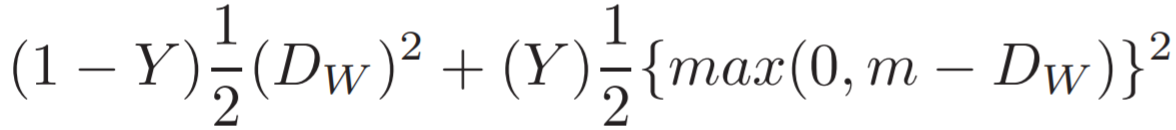

In [ ]:
import tensorflow as tf

def contrastive_loss(y_true, y_pred, margin=1):
    '''Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        A tensor containing contrastive loss as floating point value.
    '''

    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

### Contrastive Loss Function Alternative - 2

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K

def contrastive_loss(y_true, y_pred, margin=1):
    '''Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        A tensor containing contrastive loss as floating point value.
    '''
    y_true =tf.dtypes.cast(y_true, tf.float64)   # Casts a tensor to a new type.
    y_pred =tf.dtypes.cast(y_pred, tf.float64)
    margin = tf.dtypes.cast(margin, tf.float64)

    square_pred = K.square(y_pred)    # ||F(A)-F(B)||^2
    margin      = K.square(margin)

    # Loss function Le Cunn
    margin_square = K.square(K.maximum((margin - y_pred), 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

### SSIM Loss

SSIM measures Structural Similarity between two images in terms of luminance, contrast, and structure. A value of 1 for SSIM indicates identical images. You want the SSIM loss function to be a minimum when training the autoencoder on good images.

![](https://vicuesoft.com/glossary/ssim-ms-ssim.png)

The SSIM index is a development of traditional methods such as PSNR (peak signal-to-noise ratio) and the MSE method, which turned out to be incompatible with the physiology of human perception. The difference with other techniques such as MSE or PSNR is that these approaches estimate absolute errors. Structural information is the idea that the pixels have strong inter-dependencies especially when they are spatially close. These dependencies carry important information about the structure of the objects in the visual scene.

The SSIM index is calculated on various windows of an image. The above formula is applicable only for the brightness of the image, which is used to assess the quality. The resulting SSIM index ranges from -1 to +1. A value of +1 is achieved only with the complete authenticity of the samples. Typically, the metric is calculated for an 8 x 8 pixel window. The window can be displaced by a pixel, but experts recommend using groups of windows to reduce the complexity of the calculations.

A more advanced form of SSIM, called **Multiscale SSIM (MS-SSIM)**, is performed at multiple scales through a multi-step downsampling process, reminiscent of multiscale processing in the early visual system. It has been shown to perform equally well or better than SSIM with various databases of subjective images and videos.

In [ ]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

# Example Usage
# model.compile(optimizer=optimizer, loss=SSIMLoss)

### Save custom Model

In [ ]:
from datetime import datetime

def save_custom_model(model, name="model", verbose=1):
    # Get Datetime object containing current date and time
    date = str(datetime.now())
    date = (((date.replace("-", "_")).replace(":", "_")).replace(" ", "_")).split(".")[0]

    model_name = str(name) + str(date) + ".keras"
    model.save(model_name)

    if verbose > 0:
        print(f"{model_name} was saved successfully")


# # Example Usage
# save_custom_model(model, "custom_model")
# # Loading the model back
# loaded_model = keras.models.load_model('/path/to/custom_model_2023_08_16_06_45_05.keras')

### TSNE Anomaly Scatter

**Visualising clusters with t-SNE**

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction technique used for visualisations of complex datasets. It maps clusters in high-dimensional data to a two- or three dimensional plane so we can get an idea of how easy it will be to discriminate between classes. It does this by trying to keep the distance between data points in lower dimensions proportional to the probability that these data points are neighbours in the higher dimensions.


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def tsne_anomaly_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('Make sure that your dimension is 2d or 3d')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)

    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))

    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # Scattering map for Anomaly samples
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )

    # Scattering map for Normal samples
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as)
    plt.show()

# Example Usage
# tsne_scatter(features, labels, dimensions=2, save_as='tsne_2d.png')

### Visualize Triplet Images from the batches

In [ ]:
def show_triplet_images(anchor, positive, negative, size=(10,10), row=3):
  '''Visualize triplets from the batches'''
  def plot_img(ax, image):
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  fig = plt.figure(figsize=size)

  axs = fig.subplots(row, 3)
  for i in range(row):
    plot_img(axs[i, 0], anchor[i])
    plot_img(axs[i, 1], positive[i])
    plot_img(axs[i, 2], negative[i])

### Print Classification Report - Classification Evaluation Method

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score # Evaluation metrics
from sklearn.metrics import classification_report  # Precision, recall, f1-score metrics

def print_eval_parameters(model, y_test, y_pred, labels):
  '''This methods prints all evaluation parameters for classification models'''
  print("====== " + type(model).__name__ +" model Evaluation metrics ======")
  print("Accuracy of model:      {:.3f}".format(accuracy_score(y_test, y_pred)))                    # Accuracy score: (tp + tn) / (tp + fp + tn + fn)
  print("Recall of model:        {:.3f}".format(recall_score(y_test, y_pred, average="micro")))     # Recall score: tp / (tp + fn)
  print("Precision of model:     {:.3f}".format(precision_score(y_test, y_pred, average="micro")))  # Precision score: tp / (tp + fp)
  print("F1 score of model:      {:.3f}".format(f1_score(y_test, y_pred, average="micro")))         # F1 score: 2 * (precision * recall) / (precision + recall)
  # print("Mean accuracy of the model (Score):  {:.3f}".format(model.score(X_train_valid_scl, y_train_valid)))  # Print model Mean Accuracy (score)
  print("Misclassification Number: ", (y_test != y_pred).sum())
  print("\n====== " + type(model).__name__ +" model Detailed Classification Report ======")
  # Print K Nearest Neighbor model's classification report for validation set
  # Report contains; Precision, recal and F1 score values for each label and
  # model's accuracy, macro and weighted average
  print(classification_report(y_test, y_pred, target_names=labels))

### Plot Accuracy and Loss Curves from Model History - Training and Validation

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot the validation and training data separately
def plot_loss_curves(history, all_in_one=False):
  """
  Returns separate loss curves for training and validation metrics.
  """
  # <AxesSubplot:>
  if all_in_one == True:  # Plots 'loss', 'accuracy', 'val_loss', 'val_accuracy' in the same graph
    pd.DataFrame(cnn_model_history.history).plot(figsize=(10, 7))
  else:
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

# Example Usage - Train a model: model_hist = model.fit(x_train, y_train, epochs=...)
# plot_loss_curves(model_history)

### Model History Comparison (especially after Fine-tuning processes)

In [ ]:
def compare_historys(base_model_history, fine_tune_model_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get base_model history measurements
    acc = base_model_history.history["accuracy"]
    loss = base_model_history.history["loss"]

    print(len(acc))

    val_acc = base_model_history.history["val_accuracy"]
    val_loss = base_model_history.history["val_loss"]

    # Combine base_model history with fine_tune_model_history
    total_acc = acc + fine_tune_model_history.history["accuracy"]
    total_loss = loss + fine_tune_model_history.history["loss"]

    total_val_acc = val_acc + fine_tune_model_history.history["val_accuracy"]
    total_val_loss = val_loss + fine_tune_model_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

### Show Confusion Matrix - Classification Evaluation Method

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False, fig_name='confusion_matrix'):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  '''
  >> A = np.array([2,0,1,8])
  >> A.shape
  Output: (4,)

  >> A[np.newaxis, :]
  Output: array([[2,0,1,8]])

  >> A[:, np.newaxis]
  Output: array([[2],
                 [0],
                 [1],
                 [8]]
  )
  '''
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig_name = fig_name + '.png'
    fig.savefig(fig_name)

Show Confusion Matrix - Classification Evaluation Method (Alternative - 2)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Classifier Confusion Matrix visualization
import matplotlib.pyplot as plt

def show_confusion_matrix(y_test, y_pred, labels, w_h=(12, 7)):
  '''This method plots Confusion matrix for classification models with given test dataset and prediction result array'''
  confMatrix = confusion_matrix(y_test, y_pred)
  dispConfMatrix = ConfusionMatrixDisplay(confMatrix, display_labels=labels)
  dispConfMatrix.plot()
  fig = plt.gcf()
  w, h = w_h
  fig.set_size_inches(w, h)

### Plot Randomly Image Predictions

In [ ]:
import matplotlib.pyplot as plt

def plot_randomly_img_predictions(img_arr, y_test, y_pred, labels, num_item=2, fig_size=[20,10]):
  plt.figure(figsize=fig_size)
  for img in range(num_item):
      ix = rnd.randint(0, len(img_arr)-1)
      display = plt.subplot(1, num_item, img+1)

  plt.imshow(img_arr[ix], cmap="gray")
  act  = "Act: " + str(labels[(int(y_test[ix]))])
  pred = "Pred: " + str(labels[(int(y_pred[ix]))])

  plt.yticks([])
  plt.title(act)
  plt.ylabel(pred)

  display.get_xaxis().set_visible(False)
  #display.get_yaxis().set_visible(False)

  plt.show()

### Show ROC Curve - Calculate AUC score

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

def show_ROC_score(self, y_test, pos_prob, kind='fp_tp', plot=False, label='Custom Classifier'):
  if kind == 'fp_tp':   # False Positive-True Positive Curve
    auc_score = roc_auc_score(y_test, pos_prob)
    fp_rate, tp_rate, thresholds = roc_curve(y_test, pos_prob)
    plt_x, plt_y, lbl_x, lbl_y = fp_rate, tp_rate, "False Positive Rate (FP)", "True Positive Rate (TP)"
    # Generate a no skill prediction
    noskill_probs = [0 for _ in range(len(y_test))]
    ns_auc_score = roc_auc_score(y_test, noskill_probs)
    noskill_fp_rate, noskill_tp_rate, noskill_thresholds = roc_curve(y_test, noskill_probs)

  elif kind == 'pre_rec':   # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, pos_prob)
    auc_score = auc(recall, precision)
    plt_x, plt_y, lbl_x, lbl_y = recall, precision, "Recall", "Precision"
  else:
    raise ValueError("Use 'fp_tp' or 'pre_rec' as kind parameter")

  print("AUC: ", auc_score)
  if kind == 'fp_tp':
    print("No-skill AUC: ", ns_auc_score)
  print("")

  if plot == True:
    plt.title("ROC Curve")
    plt.plot(plt_x, plt_y, marker='.', label=label)
    if kind == 'fp_tp':
      plt.plot(noskill_fp_rate, noskill_tp_rate, linestyle='--', label='No Skill Classifer')
    plt.xlabel(lbl_x)
    plt.ylabel(lbl_y)
    plt.legend()
    plt.show()

### Visualize Models

Block-wise model architecture visualization for Convolutional Networks

In [ ]:
!pip install visualkeras  # Install visualkeras package if requirements are not satisfied

import visualkeras

visualkeras.layered_view(model
                         ,legend=True
                         #,draw_volume=False
                         #,spacing=30
                         )

Flow chart based model architecture drawing

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model,
           to_file='model_plot.png',
           show_shapes=True,
           rankdir='LR'  # 'BT': Bottom to Top, 'TB': Top to Bottom, 'RL': Right to Left, 'LR': Left to Right
           show_layer_names=True)

### Reference

https://github.com/keras-team

https://github.com/mrdbourke/tensorflow-deep-learning/tree/main

https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders#Unsupervised-Learning-with-Auto-Encoders

https://pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/

https://www.kaggle.com/code/matheusfacure/semi-supervised-anomaly-detection-survey

https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1

https://lilianweng.github.io/posts/2018-08-12-vae/